In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
train_set = MNIST('.MNIST', transform=transforms.ToTensor(), train=True, download=True)
val_set = MNIST('.MNIST', transform=transforms.ToTensor(), train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .MNIST/MNIST/raw/train-images-idx3-ubyte.gz to .MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to .MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to .MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to .MNIST/MNIST/raw



In [5]:
x, y = train_set[0]
x.shape

torch.Size([1, 28, 28])

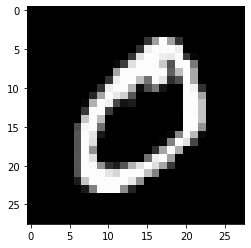

0


In [6]:
import matplotlib.pyplot as plt 

x, y = train_set[1] 
plt.imshow(x[0,:,:], cmap='gray')
plt.show()
print(y)

In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [8]:
from torch import nn 
import torch.nn.functional as F 
import torch

class MLP(nn.Module):
    def __init__(self, hidden_size):
        super().__init__() 
 
        self.linear1 = nn.Linear(784, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 10)


    def forward(self, x):
        # (batch_size, 1, 28, 28)
        x = torch.flatten(x, start_dim=1)
        # (batch_size, 784)
        x = self.linear1(x) 
        x = F.relu(x)
        x = self.linear2(x) 
        return x

In [9]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([64, 1, 28, 28])

In [10]:
net = MLP(hidden_size=100)

In [12]:
net(batch[0]).shape

torch.Size([64, 10])

In [13]:
def test(net, loader):
    net.eval()

    correct, total = 0, 0

    for batch in loader: 
        images, labels = batch[0], batch[1]
        images = images.to('cuda')
        labels = labels.to('cuda')

        with torch.no_grad():
            out = net(images)
        pred = torch.argmax(out, dim=1)

        total += len(pred)
        correct += (pred == labels).cpu().numpy().sum()

    return correct / total

In [22]:
net = MLP(hidden_size=100)
net = net.to('cuda')

In [23]:
test(net, train_loader)

0.10283333333333333

In [24]:
def train(net, train_loader, val_loader, optimizer, epochs=10):
    net.train()

    for epoch in range(epochs):

        correct, total = 0, 0

        for batch in train_loader: 
            images, labels = batch[0], batch[1]
            images = images.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            out = net(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(out, dim=1)

            total += len(pred)
            correct += (pred == labels).detach().cpu().numpy().sum()

        print(f"Epoch: {epoch}")
        print(f"train accuracy: {correct / total}")
        print(f"val accuracy: {test(net, val_loader)}")

In [25]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [26]:
train(net, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.9224
val accuracy: 0.9602
Epoch: 1
train accuracy: 0.9654
val accuracy: 0.9685
Epoch: 2
train accuracy: 0.97415
val accuracy: 0.9699
Epoch: 3
train accuracy: 0.9786833333333333
val accuracy: 0.9735
Epoch: 4
train accuracy: 0.9828166666666667
val accuracy: 0.9699
Epoch: 5
train accuracy: 0.98345
val accuracy: 0.9726
Epoch: 6
train accuracy: 0.9863
val accuracy: 0.9736
Epoch: 7
train accuracy: 0.9887833333333333
val accuracy: 0.9718
Epoch: 8
train accuracy: 0.98965
val accuracy: 0.9734
Epoch: 9
train accuracy: 0.9908166666666667
val accuracy: 0.975


In [ ]:
#hyperparameters:
# 0) epochs
# 1) learning rate, hidden_size 
# 2) optimizer, momentum, batch_size

In [28]:
net = MLP(hidden_size=100)
net = net.to('cuda')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train(net, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.90415
val accuracy: 0.9377
Epoch: 1
train accuracy: 0.9507666666666666
val accuracy: 0.9578
Epoch: 2
train accuracy: 0.9644
val accuracy: 0.9669
Epoch: 3
train accuracy: 0.9721333333333333
val accuracy: 0.9697
Epoch: 4
train accuracy: 0.9775833333333334
val accuracy: 0.9731
Epoch: 5
train accuracy: 0.9816666666666667
val accuracy: 0.9741
Epoch: 6
train accuracy: 0.9840333333333333
val accuracy: 0.9744
Epoch: 7
train accuracy: 0.9868333333333333
val accuracy: 0.9753
Epoch: 8
train accuracy: 0.9889
val accuracy: 0.9745
Epoch: 9
train accuracy: 0.99065
val accuracy: 0.9758


In [29]:
test(net, val_loader)

0.9758

In [30]:
torch.save(net.state_dict(), "weights.pt")

In [31]:
net.state_dict().keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])

In [34]:
net = MLP(hidden_size=100).to('cuda')
test(net, val_loader)

0.1043

In [35]:
net.load_state_dict(torch.load("weights.pt"))
test(net, val_loader)

0.9758